## Calculations of the Absorption Spectrum for Pyrene and PAA

This code uses the QC_analysis module, which reads and imports data from Qchem output files. Specifically, it takes in
frequency and force outputs and calculates the required parameters used in the absorption response function. The module
comes with a function 'abs_spec' that takes in these parameters and outputs the fourier transform of the response
function, giving the absorption power spectrum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import QC_analysis as QC

def normalize(arr):
    max = np.amax(arr)
    normed = arr/max
    return normed

def plot_params():
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel(r'Intensity', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'Wavenumbers / $\mathrm{cm}^{-1}$', fontsize=20)
    plt.xticks(fontsize=20)
    plt.locator_params(axis='x', nbins=5)
    plt.gca().xaxis.set_tick_params(width=2)
    plt.gca().yaxis.set_tick_params(width=2)
    plt.xlim(27000, 38000)
    legend = plt.legend(frameon=False, fontsize=16, loc='upper right')
    legend.get_title().set_fontsize('20')

ps2AU = 1/2.4189e-5

* 'QC.ImportData' creates an object that will contain the output information from QChem. It takes in a list of QChem output
files.
* Calling the function 'import_freq_data' finds data related to the QChem frequency calculations. You need to specify which file to analyze using 'file_number'.
* Likewise 'import_force_data' finds data related to force calculations.
* 'diag_mw_hessian' performs an eiganvalue decomposition of the mw_hessian matrix from the QChem frequency analysis and stores the resulting normal modes and vibrational frequencies.
* 'calc_HR' uses outputs from the QChem force calculation and frequency analysis to determine Huang-Rhys factors for each vibrational mode.
* 'QC.abs_spec' calculates the absorption spectrum based on the frequencies and Huang-Rhy factors associated with each normal mode. It also requires a temperature and an inhomogeneous broadening value.

In [2]:
PAA_data = QC.ImportData(['PAA_geoopt_freq.out', 'PAA_force.out'])
PAA_data.import_freq_data(file_number=0, mw_hessian=True)
PAA_data.import_force_data(file_number=1)
PAA_data.diag_mw_hessian()
PAA_data.calc_HR()

In [4]:
# Define time axis
totalTime = 10  # ps
totalSteps = 100000
timeRangeAU = np.linspace(0, totalTime * ps2AU, totalSteps)

## Caluclated and Experimental absorption spectra of PAA

In [5]:
E0 = 344.4  # nm
T = 300  # Kelvin
inhomBroadening = 200  # cm-1

T = 300  # Kelvin
inhomBroadening = 200  # cm-1
freqAxis, PAA_spec_hot = QC.abs_spec(E0, PAA_data.mw_frequencies, PAA_data.hr, T, inhomBroadening, timeRangeAU)
T = 0.1
inhomBroadening = 10  # cm-1
freqAxis, PAA_spec_frozen = QC.abs_spec(E0, PAA_data.mw_frequencies, PAA_data.hr, T, inhomBroadening, timeRangeAU)

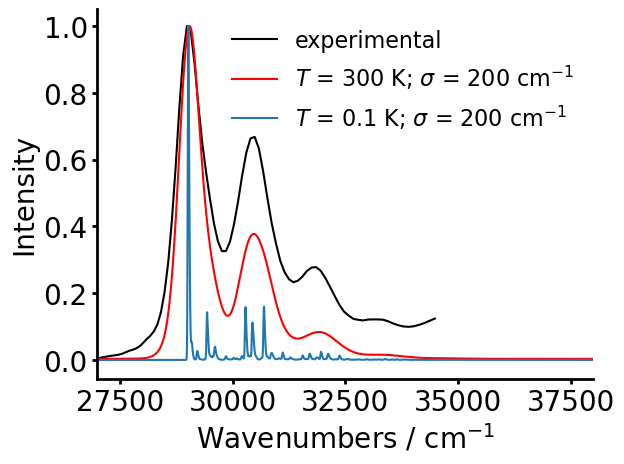

In [6]:
plt.figure()
exp_abs = np.loadtxt('PAA_abs.txt')
plt.plot(1e7/exp_abs[61:,0], normalize(exp_abs[61:, 1]), color='k', label='experimental')
plt.plot(freqAxis, normalize(PAA_spec_hot), 'r', label='$T$ = 300 K; $\sigma$ = 200 $\mathrm{cm}^{-1}$')
plt.plot(freqAxis, normalize(PAA_spec_frozen), 'tab:blue', label='$T$ = 0.1 K; $\sigma$ = 200 $\mathrm{cm}^{-1}$')
plot_params()
plt.savefig('Figure_5b.eps', format='eps', bbox_inches='tight')

## Caluclated and Experimental absorption spectra of Pyrene

In [7]:
pyrene_data = QC.ImportData(['pyrene_geoopt_freq.out', 'pyrene_force.out'])
pyrene_data.import_freq_data(file_number=0, mw_hessian=True)
pyrene_data.import_force_data(file_number=1)
pyrene_data.diag_mw_hessian()
pyrene_data.calc_HR()

In [8]:
E0 = 335.5  # nm
T = 300  # Kelvin
inhomBroadening = 200  # cm-1

T = 300  # Kelvin
inhomBroadening = 200  # cm-1
freqAxis, pyrene_spec_hot = QC.abs_spec(E0, pyrene_data.mw_frequencies, pyrene_data.hr, T, inhomBroadening, timeRangeAU)
T = 10
inhomBroadening = 10  # cm-1
freqAxis, pyrene_spec_frozen = QC.abs_spec(E0, pyrene_data.mw_frequencies, pyrene_data.hr, T, inhomBroadening, timeRangeAU)

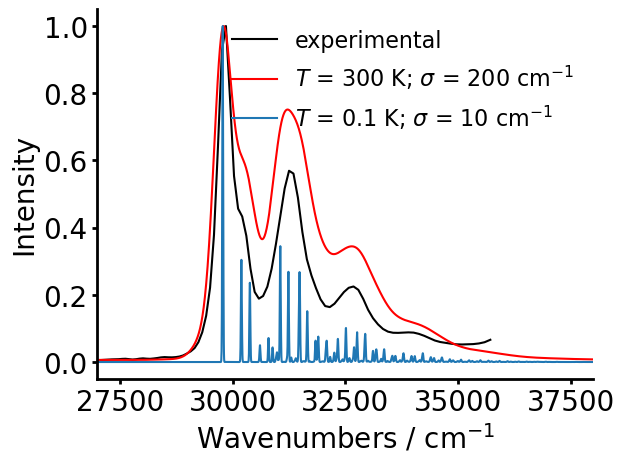

In [9]:
plt.figure()
exp_abs = np.loadtxt('pyrene_abs.txt')
plt.plot(1e7/exp_abs[61:,0], normalize(exp_abs[61:, 1]), color='k', label='experimental')
plt.plot(freqAxis, normalize(pyrene_spec_hot), 'r', label='$T$ = 300 K; $\sigma$ = 200 $\mathrm{cm}^{-1}$')
plt.plot(freqAxis, normalize(pyrene_spec_frozen), 'tab:blue', label='$T$ = 0.1 K; $\sigma$ = 10 $\mathrm{cm}^{-1}$')
plot_params()
plt.savefig('Figure_5a.eps', format='eps', bbox_inches='tight')

## PAA Huang-Rhys factors and IR Dipole Comparison


In [20]:
PAA_dataES = QC.ImportData(['PAA_esVib_gsGeo.out'])
PAA_dataES.import_freq_data(file_number=0, mw_hessian=True)
PAA_dataES.diag_mw_hessian()
prob = PAA_data.norms_from_mw_hess.T.dot(PAA_dataES.norms_from_mw_hess) ** 2
maxIndx = np.argmax(prob[6:, 6:], 1)
IR_gs = PAA_dataES.ir_dipole[maxIndx, :]
normIR_gs = np.sum(IR_gs**2, 1)**0.5
sThresh = np.argwhere(PAA_data.hr > 0.012)[:, 0]

C:\Users\conno\OneDrive - Northwestern University\GitHub\ESVP\Qchem_analysis\QC_analysis.py:115: RuntimeWarning: invalid value encountered in sqrt
  self.mw_frequencies = np.sqrt(self.eigVals_from_mw_hess) * vib_constant


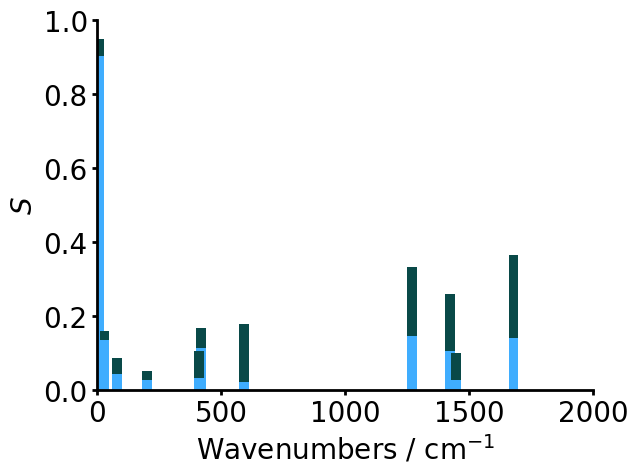

In [21]:
plt.bar(PAA_data.frequency[sThresh], PAA_data.hr[sThresh], 40, color='#3FADFE')
plt.bar(PAA_data.frequency[sThresh], normIR_gs[sThresh], 40, bottom=PAA_data.hr[sThresh], color='#094948')
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel(r'$S$', fontsize=20)
plt.ylim(0, 1)
plt.yticks(fontsize=20)
plt.xlabel(r'Wavenumbers / $\mathrm{cm}^{-1}$', fontsize=20)
plt.xlim(0, 2000)
plt.xticks(fontsize=20)
plt.locator_params(axis='x', nbins=5)
plt.gca().xaxis.set_tick_params(width=2)
plt.gca().yaxis.set_tick_params(width=2)
plt.savefig('Figure_5d.eps', format='eps', bbox_inches='tight')

## Pyrene Huang-Rhys factors and IR Dipole Comparison

In [22]:
pyrene_dataES = QC.ImportData(['pyrene_esVib_gsGeo.out'])
pyrene_dataES.import_freq_data(file_number=0, mw_hessian=True)
pyrene_dataES.diag_mw_hessian()
prob = pyrene_data.norms_from_mw_hess.T.dot(pyrene_dataES.norms_from_mw_hess) ** 2
maxIndx = np.argmax(prob[6:, 6:], 1)
IR_gs = pyrene_dataES.ir_dipole[maxIndx, :]
normIR_gs = np.sum(IR_gs**2, 1)**0.5
sThresh = np.argwhere(pyrene_data.hr > 0.012)[:, 0]

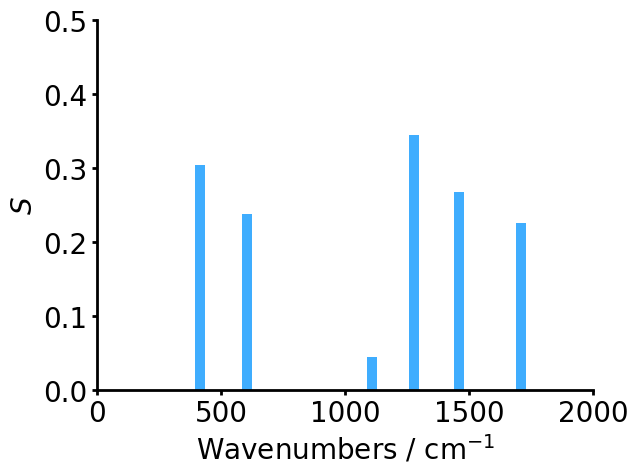

In [23]:
plt.bar(pyrene_data.frequency[sThresh], pyrene_data.hr[sThresh], 40, color='#3FADFE')
plt.bar(pyrene_data.frequency[sThresh], normIR_gs[sThresh], 40, bottom=pyrene_data.hr[sThresh], color='#094948')
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel(r'$S$', fontsize=20)
plt.ylim(0, 0.5)
plt.yticks(fontsize=20)
plt.xlabel(r'Wavenumbers / $\mathrm{cm}^{-1}$', fontsize=20)
plt.xlim(0, 2000)
plt.xticks(fontsize=20)
plt.locator_params(axis='x', nbins=5)
plt.gca().xaxis.set_tick_params(width=2)
plt.gca().yaxis.set_tick_params(width=2)
plt.savefig('Figure_5c.eps', format='eps', bbox_inches='tight')